In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, RocCurveDisplay, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/prediction leaving of customers/customer_churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
def ana_des(dataframe):
    print("=======================Index=========================\n")
    print(f"{dataframe.index}\n\n")
    print("=======================Columns=========================\n")
    print(f"{dataframe.columns}\n\n")
    print("=======================Descritive=========================\n")
    print(f"{dataframe.describe()}\n\n")
    print("=======================Dtype=========================\n")
    print(f"{dataframe.dtypes}\n\n")
    print("=======================Null Value=========================\n")
    print(f"{dataframe.isnull().sum()}\n\n")
    print("=======================Unique Value=========================\n")
    print(f"{dataframe.nunique()}\n\n")

ana_des(df)

=======================Index=========================

RangeIndex(start=0, stop=7043, step=1)


=======================Columns=========================

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


=======================Descritive=========================

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max 

### Featuring data

In [ ]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [ ]:
df.drop('customerID', axis=1, inplace=True)

In [ ]:
df['TotalCharges'].value_counts()

TotalCharges
          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: count, Length: 6531, dtype: int64

In [ ]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')

In [ ]:
df['TotalCharges'] = df['TotalCharges'].replace(' ',0)

In [ ]:
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [ ]:
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == object:
        df[col] = le.fit_transform(df[col])
        df[col] = df[col].astype('category')

In [ ]:
le = LabelEncoder()
le.fit(df["Churn"])
with open('encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [ ]:
with open('label_encoder_weights.pkl', 'wb') as f:
    pickle.dump(le, f)

In [ ]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [ ]:
df["gender"].dtypes

CategoricalDtype(categories=[0, 1], ordered=False)

In [ ]:
for i in df.columns:
    if (df[i].dtype == int) or (df[i].dtype == float):
        print(i)

tenure
MonthlyCharges
TotalCharges


In [ ]:
df["gender"] = df["gender"].astype('category')

In [ ]:
num_cols = [x for x in df.columns if (df[x].dtype == int) or (df[x].dtype == float)]
print(num_cols)

['tenure', 'MonthlyCharges', 'TotalCharges']


In [ ]:
cat_cols = []
for col in df.columns:
    if df[col].dtype == object:
        cat_cols.append(col)

In [ ]:
cat_cols.insert(1,'SeniorCitizen')

In [ ]:
cat_cols = cat_cols[:-1]

In [ ]:
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [ ]:
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}

    def fit(self, X, y=None):
        for col in X.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.encoders[col] = le
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in X.columns:
            X_transformed[col] = self.encoders[col].transform(X[col])
        return X_transformed

    def save_encoders(self, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(self.encoders, f)

    def load_encoders(self, filepath):
        with open(filepath, 'rb') as f:
            self.encoders = pickle.load(f)

In [ ]:
# Scale dữ liệu
ct = ColumnTransformer(
    [("scale1", StandardScaler(), num_cols),
     ("encoder", MultiColumnLabelEncoder(), cat_cols)
     ], remainder="passthrough")
df = ct.fit_transform(df.iloc[:,:-1])

In [ ]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
list(cat_cols)

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [ ]:
with open('column_transformer.pkl', 'wb') as f:
    pickle.dump(ct, f)

# To load the ColumnTransformer later
with open('column_transformer.pkl', 'rb') as f:
    loaded_column_transformer = pickle.load(f)

In [ ]:
all_cols = num_cols + cat_cols[:-1]

In [ ]:
all_cols

['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [ ]:
df

array([[-1.27744458, -1.16032292, -0.99261052, ...,  0.        ,
         1.        ,  2.        ],
       [ 0.06632742, -0.25962894, -0.17216471, ...,  1.        ,
         0.        ,  3.        ],
       [-1.23672422, -0.36266036, -0.9580659 , ...,  0.        ,
         1.        ,  3.        ],
       ...,
       [-0.87024095, -1.1686319 , -0.85293201, ...,  0.        ,
         1.        ,  2.        ],
       [-1.15528349,  0.32033821, -0.87051315, ...,  0.        ,
         1.        ,  3.        ],
       [ 1.36937906,  1.35896134,  2.01389665, ...,  2.        ,
         1.        ,  0.        ]])

In [ ]:
df.iloc[:,:-1]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60


In [ ]:
transformed_data = loaded_column_transformer.transform(df.iloc[:,:-1])

# Convert the transformed data back to a DataFrame for readability
transformed_df = pd.DataFrame(
    transformed_data,
    columns=all_cols
)

In [ ]:

transformed_df

,tenure,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,-1.277445,-1.160323,-0.992611,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,0.066327,-0.259629,-0.172165,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0
2,-1.236724,-0.362660,-0.958066,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
3,0.514251,-0.746535,-0.193672,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0
4,-1.236724,0.197365,-0.938874,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.340876,0.665992,-0.127605,1.0,0.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0
7039,1.613701,1.277533,2.242606,0.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,1.0,1.0
7040,-0.870241,-1.168632,-0.852932,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
7041,-1.155283,0.320338,-0.870513,1.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0


In [ ]:
import json

def pipeline_processing(data_set):

    # Convert the JSON dictionary to a JSON string
    json_string = json.dumps(data_set)

    # Load JSON data
    parsed_json = json.loads(json_string)

    # Convert into DataFrame
    df = pd.DataFrame(parsed_json, index=[0])

    # Drop customerID
    df.drop('customerID', axis=1, inplace=True)


    """
    Preprossing data
    """

    df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')
    df['TotalCharges'] = df['TotalCharges'].astype(float)

    # Encoder - Scaler
    with open('column_transformer.pkl', 'rb') as f:
        loaded_column_transformer = pickle.load(f)

    all_cols =['tenure',
                'MonthlyCharges',
                'TotalCharges',
                'gender',
                'SeniorCitizen',
                'Partner',
                'Dependents',
                'PhoneService',
                'MultipleLines',
                'InternetService',
                'OnlineSecurity',
                'OnlineBackup',
                'DeviceProtection',
                'TechSupport',
                'StreamingTV',
                'StreamingMovies',
                'Contract',
                'PaperlessBilling',
                'PaymentMethod']

    transformed_data = loaded_column_transformer.transform(df)

    # Convert the transformed data back to a DataFrame for readability
    transformed_df = pd.DataFrame(
        transformed_data,
        columns=all_cols
    )

    order_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
    'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
    'MonthlyCharges', 'TotalCharges']

    new_df = pd.DataFrame()
    for col in order_cols:
        new_df[col] = transformed_df[col]

    new_df_value = new_df.values.flatten().tolist()

    # Convert to the required JSON format
    result_json = {
        "data": new_df_value
    }

    return result_json

In [ ]:
json_data = {
    "customerID":"7590-VHVEG",
    "gender":"Female",
    "SeniorCitizen":0,
    "Partner":"Yes",
    "Dependents":"No",
    "tenure":1,
    "PhoneService":"No",
    "MultipleLines":"No phone service",
    "InternetService":"DSL",
    "OnlineSecurity":"No",
    "OnlineBackup":"Yes",
    "DeviceProtection":"No",
    "TechSupport":"No",
    "StreamingTV":"No",
    "StreamingMovies":"No",
    "Contract":"Month-to-month",
    "PaperlessBilling":"Yes",
    "PaymentMethod":"Electronic check",
    "MonthlyCharges":29.85,
    "TotalCharges":"29.85"
}

output = pipeline_processing(json_data)

In [ ]:
output

{'data': [0.0,
  0.0,
  1.0,
  0.0,
  -1.2774445836787656,
  0.0,
  1.0,
  0.0,
  0.0,
  2.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  2.0,
  -1.1603229160349193,
  -0.9926105235902257]}

In [ ]:
pred_value

array([1])

In [ ]:
order_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
'MonthlyCharges', 'TotalCharges']

new_df = pd.DataFrame()
for col in order_cols:
    new_df[col] = transformed_df[col]


In [ ]:
new_df.values

array([[ 0.        ,  0.        ,  1.        , ...,  2.        ,
        -1.16032292, -0.99261052],
       [ 1.        ,  0.        ,  0.        , ...,  3.        ,
        -0.25962894, -0.17216471],
       [ 1.        ,  0.        ,  0.        , ...,  3.        ,
        -0.36266036, -0.9580659 ],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  2.        ,
        -1.1686319 , -0.85293201],
       [ 1.        ,  1.        ,  1.        , ...,  3.        ,
         0.32033821, -0.87051315],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.35896134,  2.01389665]])

In [ ]:
# Save the LabelEncoders
cat_transformer = ct.named_transformers_['encoder']
cat_transformer.save_encoders('label_encoders.pkl')

In [ ]:
# Load the encoders and use them again later
cat_transformer.load_encoders('label_encoders.pkl')

UnpicklingError: invalid load key, '\xef'.

In [ ]:
ct_nor = ColumnTransformer(
    [("scale1", StandardScaler(), num_cols)
     ], remainder="passthrough")
df[num_cols] = ct_nor.fit_transform(df[num_cols])

In [ ]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,-1.277445,0,1,0,0,2,0,0,0,0,0,1,2,-1.160323,-0.992611,0
1,1,0,0,0,0.066327,1,0,0,2,0,2,0,0,0,1,0,3,-0.259629,-0.172165,0
2,1,0,0,0,-1.236724,1,0,0,2,2,0,0,0,0,0,1,3,-0.362660,-0.958066,1
3,1,0,0,0,0.514251,0,1,0,2,0,2,2,0,0,1,0,0,-0.746535,-0.193672,0
4,0,0,0,0,-1.236724,1,0,1,0,0,0,0,0,0,0,1,2,0.197365,-0.938874,1


In [ ]:
X = df.drop('Churn', axis=1).values
y = df['Churn'].values

# smote = SMOTE(random_state=42)
smote = RandomOverSampler(random_state=42)
X ,y = smote.fit_resample(X,y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# def val_model(model, X_train, X_val, y_train, y_val):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_val)
#     print(classification_report(y_val, y_pred))

In [ ]:
seed = 42

hyper_models = {
    'Decision Tree':{
        'model':DecisionTreeClassifier(random_state=seed),
        'params':{
            'criterion':['gini', 'entropy', 'log_loss'],
            'max_depth':[5,8,10,15]
        }
    },
    'Random Forest':{
        'model':RandomForestClassifier(random_state=seed),
        'params':{
            'criterion':['gini', 'entropy', 'log_loss'],
            'max_depth':[10,15, 17, 20],
            'n_estimators':[100,200,300]
        }
    },
    'XGBoost':{
        'model': XGBClassifier(random_state=seed),
        'params':{
            'n_estimators':[100,200,300],
            'max_depth':[3,5,8,10,15],
            'learning_rate':[0.1,0.2]
        }
    },
    'LightGBM':{
        'model': LGBMClassifier(random_state=seed),
        'params':{
            'n_estimators':[100,200,300],
            'max_depth':[3,5,8,10,15]
        }
    },
    'GradientBoosting':{
        'model':GradientBoostingClassifier(random_state=seed) ,
        'params':{
            'n_estimators':[100,200,300],
            'learning_rate':[0.1,0.2]
        }
    },
    'K Neighbors':{
        'model': KNeighborsClassifier(),
        'params':{
            'n_neighbors':[2,3,5],
            'weights': ['uniform', 'distance']
        }
    }
}

scores = []

for model_name, mp in hyper_models.items():
    clf = GridSearchCV(mp['model'], mp['params'],cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model':model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

results_train = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
results_train

[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

,model,best_score,best_params
0,Decision Tree,0.857849,"{'criterion': 'gini', 'max_depth': 15}"
1,Random Forest,0.902206,"{'criterion': 'gini', 'max_depth': 20, 'n_esti..."
2,XGBoost,0.898535,"{'learning_rate': 0.2, 'max_depth': 15, 'n_est..."
3,LightGBM,0.870992,"{'max_depth': 15, 'n_estimators': 300}"
4,GradientBoosting,0.822866,"{'learning_rate': 0.2, 'n_estimators': 300}"
5,K Neighbors,0.867418,"{'n_neighbors': 2, 'weights': 'distance'}"


In [ ]:
dt_model = DecisionTreeClassifier(max_depth=15, criterion='gini')
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_val)
print(classification_report(y_val, y_pred_dt))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83      1574
           1       0.79      0.93      0.85      1531

    accuracy                           0.85      3105
   macro avg       0.85      0.85      0.84      3105
weighted avg       0.85      0.85      0.84      3105



In [ ]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, criterion='gini')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)
print(classification_report(y_val, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1574
           1       0.84      0.95      0.89      1531

    accuracy                           0.89      3105
   macro avg       0.89      0.89      0.89      3105
weighted avg       0.89      0.89      0.89      3105



In [ ]:
# Save model
with open('model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Load model
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

pred = model.predict(X_val)
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1574
           1       0.84      0.95      0.89      1531

    accuracy                           0.89      3105
   macro avg       0.89      0.89      0.89      3105
weighted avg       0.89      0.89      0.89      3105



In [ ]:
xgb_model  = XGBClassifier(learning_rate=0.2, max_depth=15, n_estimators=300)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)
print(classification_report(y_val, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1574
           1       0.84      0.95      0.89      1531

    accuracy                           0.89      3105
   macro avg       0.89      0.89      0.89      3105
weighted avg       0.89      0.89      0.89      3105



In [ ]:
lgb_model = LGBMClassifier(max_depth=15, n_estimators=300)
lgb_model.fit(X_train, y_train)
y_pred_lgbm = lgb_model.predict(X_val)
print(classification_report(y_val, y_pred_lgbm))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3643, number of negative: 3600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 7243, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502968 -> initscore=0.011874
[LightGBM] [Info] Start training from score 0.011874
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
              precision    recall  f1-score   support

   

In [ ]:
grad_model = GradientBoostingClassifier(learning_rate=0.2, n_estimators=300)
grad_model.fit(X_train, y_train)
y_pred_grad = grad_model.predict(X_val)
print(classification_report(y_val, y_pred_grad))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1574
           1       0.79      0.90      0.84      1531

    accuracy                           0.83      3105
   macro avg       0.84      0.83      0.83      3105
weighted avg       0.84      0.83      0.83      3105



In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_val)
print(classification_report(y_val, y_pred_knn))

              precision    recall  f1-score   support

           0       0.94      0.72      0.81      1574
           1       0.77      0.95      0.85      1531

    accuracy                           0.83      3105
   macro avg       0.85      0.83      0.83      3105
weighted avg       0.85      0.83      0.83      3105



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
input_dim = 19
output_dim = 2

model = Sequential()
# Add the input layer
model.add(Dense(units=64, activation='relu', input_dim=input_dim))

# Add more hidden layers
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.07))

# Add the output layer
model.add(Dense(units=2, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32,verbose=2)

Epoch 1/100
227/227 - 3s - loss: 0.5213 - accuracy: 0.7409 - val_loss: 0.4695 - val_accuracy: 0.7758 - 3s/epoch - 13ms/step
Epoch 2/100
227/227 - 1s - loss: 0.4925 - accuracy: 0.7599 - val_loss: 0.4562 - val_accuracy: 0.7758 - 727ms/epoch - 3ms/step
Epoch 3/100
227/227 - 1s - loss: 0.4823 - accuracy: 0.7703 - val_loss: 0.4635 - val_accuracy: 0.7671 - 760ms/epoch - 3ms/step
Epoch 4/100
227/227 - 1s - loss: 0.4718 - accuracy: 0.7780 - val_loss: 0.4519 - val_accuracy: 0.7845 - 692ms/epoch - 3ms/step
Epoch 5/100
227/227 - 1s - loss: 0.4664 - accuracy: 0.7730 - val_loss: 0.4409 - val_accuracy: 0.7849 - 916ms/epoch - 4ms/step
Epoch 6/100
227/227 - 1s - loss: 0.4446 - accuracy: 0.7886 - val_loss: 0.4553 - val_accuracy: 0.7874 - 1s/epoch - 5ms/step
Epoch 7/100
227/227 - 1s - loss: 0.4299 - accuracy: 0.8002 - val_loss: 0.4315 - val_accuracy: 0.7913 - 1s/epoch - 5ms/step
Epoch 8/100
227/227 - 1s - loss: 0.4150 - accuracy: 0.8048 - val_loss: 0.4371 - val_accuracy: 0.7948 - 1s/epoch - 5ms/step
Epo

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val)

98/98 [==============================] - 0s 2ms/step - loss: 0.9254 - accuracy: 0.8589


In [ ]:
y_pred_nn = model.predict(X_val)

98/98 [==============================] - 0s 2ms/step


In [ ]:
y_pred_nn

array([[3.7033655e-02, 9.6296632e-01],
       [4.3112737e-01, 5.6887263e-01],
       [9.9999970e-01, 1.8491482e-07],
       ...,
       [3.0390114e-02, 9.6960980e-01],
       [2.0071879e-05, 9.9997991e-01],
       [9.9654382e-01, 3.4562191e-03]], dtype=float32)

In [ ]:
y_pred_nn[:,0]

array([3.7033655e-02, 4.3112737e-01, 9.9999970e-01, ..., 3.0390114e-02,
       2.0071879e-05, 9.9654382e-01], dtype=float32)

In [ ]:
y_pred_nn = np.array([1 if x <= 0.5 else 0 for x in y_pred_nn[:,0]])

In [ ]:
y_val

array([1, 0, 0, ..., 1, 1, 0])

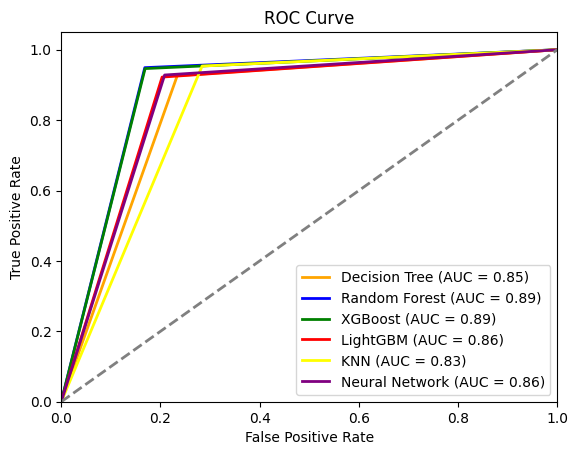

In [ ]:
from sklearn.metrics import roc_curve, auc

# Decision Tree
fpr_dt, tpr_dt, thresholds = roc_curve(y_val, y_pred_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Random Forest
fpr_rf, tpr_rf, thresholds = roc_curve(y_val, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# XGBoost
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_val, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# LightGBM
fpr_lgbm, tpr_lgbm, thresholds = roc_curve(y_val, y_pred_lgbm)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

# Gradient Boosting
fpr_grad, tpr_grad, thresholds = roc_curve(y_val, y_pred_grad)
roc_auc_grad = auc(fpr_grad, tpr_grad)

# KNN
fpr_knn, tpr_knn, thresholds = roc_curve(y_val, y_pred_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# NN
fpr_nn, tpr_nn, thresholds = roc_curve(y_val, y_pred_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Plot the ROC curves
plt.figure()
plt.plot(fpr_dt, tpr_dt, color='orange', lw=2, label='Decision Tree (AUC = %0.2f)' % roc_auc_dt)
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot(fpr_lgbm, tpr_lgbm, color='red', lw=2, label='LightGBM (AUC = %0.2f)' % roc_auc_lgbm)
plt.plot(fpr_knn, tpr_knn, color='yellow', lw=2, label='KNN (AUC = %0.2f)' % roc_auc_knn)
plt.plot(fpr_nn, tpr_nn, color='purple', lw=2, label='Neural Network (AUC = %0.2f)' % roc_auc_nn)

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# plt.figure()
# plt.boxplot(best_scores, labels=algorithm_names)
# plt.ylabel('Accuracy')
# plt.title('Best Scores for GridSearchCV')
# plt.show()

In [ ]:
# scores[0]['best_score']

In [ ]:
# for i in range(len(scores)):


In [ ]:
# plt.bar(scores[:]['model'],scores[:]['best_score'])
# plt.ylabel('Accuracy')
# plt.title('Best Scores for GridSearchCV')
# plt.show()

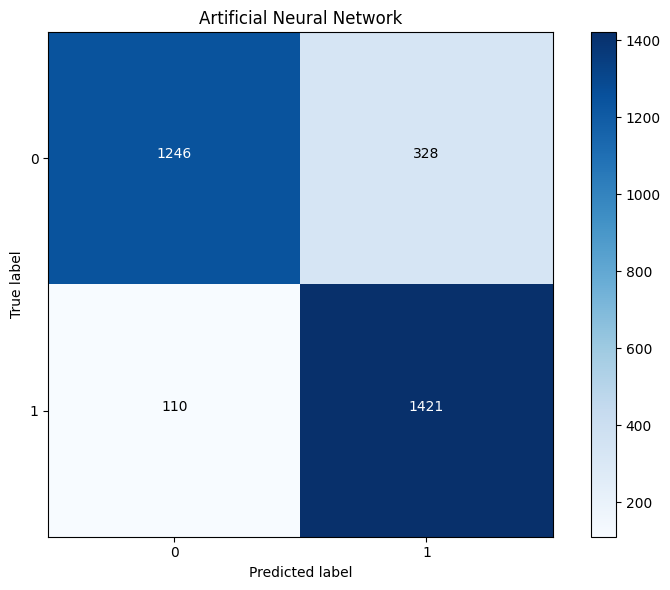

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, log_loss, balanced_accuracy_score

preds = [y_pred_dt, y_pred_rf, y_pred_xgb, y_pred_lgbm, y_pred_knn, y_pred_nn]


# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred_nn)

# Define class labels
labels = ['0', '1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Artificial Neural Network')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Fill the confusion matrix cells with values
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
log_loss(y_val, y_pred_dt)

5.583574003273864

In [ ]:
log_loss(y_val, y_pred_rf)

3.981633852646436

In [ ]:
log_loss(y_val, y_pred_xgb)

4.039675162451777

In [ ]:
log_loss(y_val, y_pred_lgbm)


5.096027000908995

In [ ]:
log_loss(y_val, y_pred_grad)

6.1523788393662135

In [ ]:
log_loss(y_val, y_pred_knn)

6.013079695833393

In [ ]:
log_loss(y_val, y_pred_nn)

5.084418738947926

In [ ]:
balanced_accuracy_score(y_val,y_pred_dt)

0.8461963968704379

In [ ]:
balanced_accuracy_score(y_val,y_pred_rf)


0.8903460212781673

In [ ]:
balanced_accuracy_score(y_val,y_pred_xgb)


0.8887220235422613

In [ ]:
balanced_accuracy_score(y_val,y_pred_lgbm)


0.8594846696439613

In [ ]:
balanced_accuracy_score(y_val,y_pred_grad)


0.8302116280478746

In [ ]:
balanced_accuracy_score(y_val,y_pred_knn)


0.8348176234151135

In [ ]:
balanced_accuracy_score(y_val,y_pred_nn)


0.8598826289716051